Quantum Real Time Evolution using Trotterization

In [9]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos

def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [('ZZ', [i, i + 1], -J) for i in range(0, L-1)]
    Z_tuples = [('Z', [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [('X', [i], -h * cos(alpha)) for i in range(0, L)]

    # Create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

In [2]:
from math import pi

H = get_hamiltonian(L=2, J=.2, h=1., alpha=pi/8)
H

SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j, -0.92387953+0.j,
 -0.92387953+0.j])

In [3]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

final_time = 1.6

# First spin up, second spin down
initial_state = Statevector.from_label('10')

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time)

In [4]:
from qiskit_algorithms import TrotterQRTE

trotter = TrotterQRTE()
result = trotter.evolve(problem)

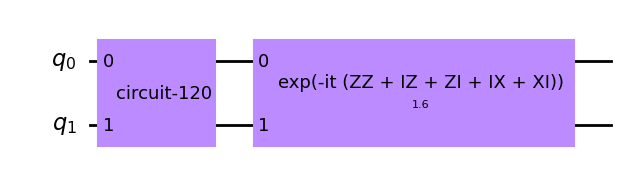

In [5]:
result.evolved_state.draw('mpl')

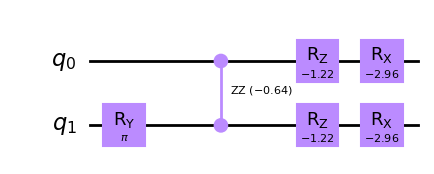

In [6]:
result.evolved_state.decompose(reps=2).decompose('disentangler_dg').decompose('multiplex1_reverse_dg').draw('mpl')

In [7]:
statevector = Statevector(result.evolved_state)
print(statevector)

Statevector([ 0.02895926+0.08738739j, -0.9411211 +0.31187756j,
              0.00811432-0.002689j  ,  0.02895926+0.08738739j],
            dims=(2, 2))


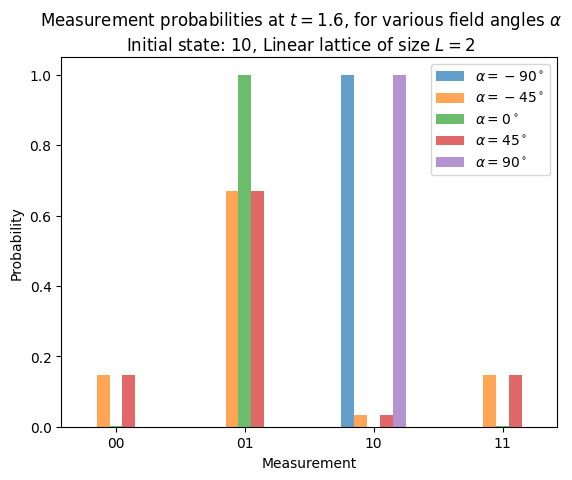

In [8]:
import numpy as np
import matplotlib.pyplot as plt

bar_width = .1
# Prepare an initial state ↑↓ (01).
# Note that Statevector and SparsePauliOp interpret the qubits from right to left
initial_state = Statevector.from_label("10")
trotter = TrotterQRTE()
final_time = 1.6
eps = 1e-5

# Create the list of angles in radians, with a small epsilon
# the exactly longitudinal field, which would present no dynamics at all
alphas = np.linspace(-np.pi/2 + eps, np.pi/2 - eps, 5)

for i, alpha in enumerate(alphas):
    H_alpha = get_hamiltonian(L=2, J=.2, h=1., alpha=alpha)
    problem = TimeEvolutionProblem(H_alpha, initial_state=initial_state, time=1.6)
    result = trotter.evolve(problem)
    evolved_state = Statevector(result.evolved_state)
    # Dictionary of probabilities
    amplitudes_dict = evolved_state.probabilities_dict()
    labels = list(amplitudes_dict.keys())
    values = list(amplitudes_dict.values())
    # Convert angle to degrees
    alpha_str = f"$\\alpha={int(np.round(alpha * 180 / pi))}^\\circ$"
    plt.bar(np.arange(4) + i * bar_width, values, bar_width, label=alpha_str, alpha=.7)

plt.xticks(np.arange(4) + 2 * bar_width, labels)
plt.xlabel("Measurement")
plt.ylabel("Probability")
plt.suptitle(
    f"Measurement probabilities at $t={final_time}$, for various field angles $\\alpha$\n"
    f"Initial state: 10, Linear lattice of size $L=2$"
)
plt.legend()